It will help customer to quiclky extract the reviews containing the exact key word or talking about the particular specification.
 
We will use the datasets from Amazon Online reviews.

we will use topic modelling for the dataset using Latent Dirichlet allocation(LDA). https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/



In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')

import pandas as pd
pd.set_option("display.max_colwidth", 1000)
import numpy as np
import re
import spacy
import gensim
from gensim import corpora

#Libraries for Visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/raman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df=pd.read_json('reviews_Automotive_5.json', lines=True)
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,"I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there.What I will say is that 12 feet really isn't an ideal length. Sure, if you pull up front bumper to front bumper they are plenty long, but a lot of times you will be beside another car or can't get really close. Because of this, I would recommend something a little longer than 12'.Great brand - get 16' version though.","08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you would see at a chinese knock off shop like harbor freight for 30 bucks.","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5,"Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps and love having a long cable so I never have to move cars around or anything if needed. I bought these to have in my new truck since you always need cables ... but another reason is for when I tow my travel trailer and we run the batteries with no shore power they may die after a couple days ... if you are in need a quick small recharge they are the perfect length to pop my hood, run the cables to the back of the truck and hook up to the batteries that are on the tongue of my travel trailer ... running the truck for 30-45 minutes with this nice large gauge wire connected from my battery tot he trailer battery will give me a bit of a charge if ever in a pinch and I have no shore power, solar, or generator to recharge.Bought the bucket boss 06009 jumper cable bag and it fit this 25 footer Pe...","07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5,"I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that not only needs to ask a kind passer-by for a ""jump"" but also if they have jumper cables. It's MUCH easier to get a jump start if you have your own cables.Next lets talk about sizing. Having the longest cable possible is a major plus if your car is parked up against something like a pole or wall, or even parked on a one way street. The ""booster car"" (the car w/o a dead battery) can pull in close enough to use the cables without having to manuver into some akward position. Or better yet, you won't have to push your vehicle into a position to be jumped. If your diving a normal sized car they can even pull in behind you to jump you! Or if their vehicle is the shorter of the two, they could pull in front. Now how about gauge? For those who aren't electricians or engineers, as the number...","12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5,"I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to store them with the carry box. These are high quality long cables of high grade materials and I believe worth the price I paid for them. They will store in the back seat storage compartment of my truck easily. Recomend.","07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000




We will be using only the reviews column that is "ReviewText"



# Data Preprocessing
We will remove the punctuations, stopwords and normalize the reviews
Check the most frequent words in the reviews

In [3]:
# Function to plot most frequent words
def mostFrequent(x,terms=30):
    all_words= ' '.join([i for i in x])
    all_words= all_words.split()
    
    fdist= FreqDist(all_words)
    words_df=pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())})
    
    # Selecting top 20 most frequent words
    d= words_df.nlargest(columns="count", n=terms)
    print(type(d))
    print('\n')
    print(d)
    
    plt.figure(figsize=(20,5))
    ax=sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel='Count')
    plt.show()

<class 'pandas.core.frame.DataFrame'>


     word  count
83    the  82515
11    and  48720
31     to  48522
2       a  45091
0       I  43185
198    it  29694
4      of  24606
38     is  24295
7     for  19683
144    in  18267
86     on  18126
175  this  17396
8      my  17235
39   that  15419
156  with  14857
49    you  14138
20   have  12704
56    but  10650
92    not   9852
308    as   9703
29    are   9355
91    was   9068
266   The   8023
58     be   7801
136    so   7037
204   use   6781
246  your   6705
36   will   6566
61     or   6552
28   they   6143


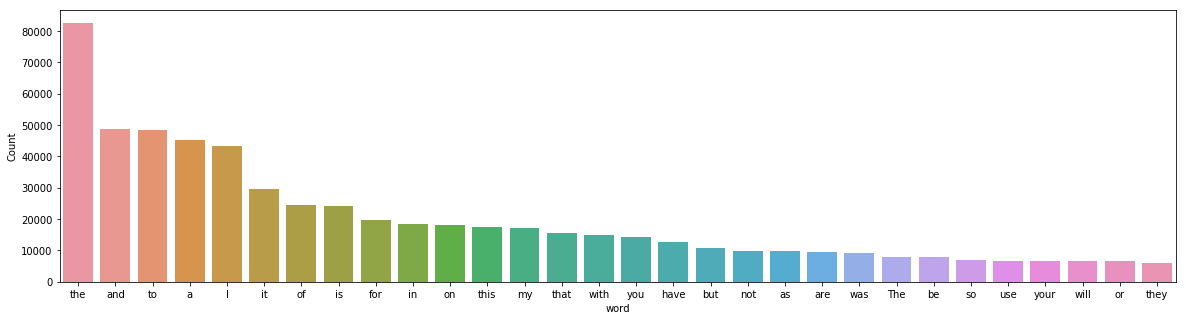

In [4]:
mostFrequent(df['reviewText'])

In [5]:
# Remove unwanted characters, numbers and symbols

df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

# Let's remove the stopwords and short words from the review
from nltk.corpus import stopwords
stop_words= stopwords.words('english')

# Function to remove stopwords
def remove_stopwords(rev):
    rev_new=" ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words
df['reviewText']= df['reviewText'].apply(lambda x: ' '.join([i for i in x.split() if len(i)>2]))

# Remove stopwords
df['reviewText']=df['reviewText'].apply(lambda x: remove_stopwords(x.split()))

# Make entire text lowercase
df['reviewText']=df['reviewText'].apply(lambda x: x.lower())


<class 'pandas.core.frame.DataFrame'>


         word  count
178       the   9984
76        use   8201
5         car   8030
175       one   7362
318      this   6303
277      well   5923
6        good   5905
38      great   5882
56       like   5825
748   product   5499
10       used   5029
33      would   4860
30        get   4790
139      time   3965
393      easy   3778
351     works   3619
43       work   3491
66       much   3437
120   battery   3269
159      also   3153
18     really   3075
412     using   3007
185    better   2887
93       need   2860
36     little   2772
890     water   2604
8       price   2570
300     light   2566
1814      oil   2543
9        they   2521


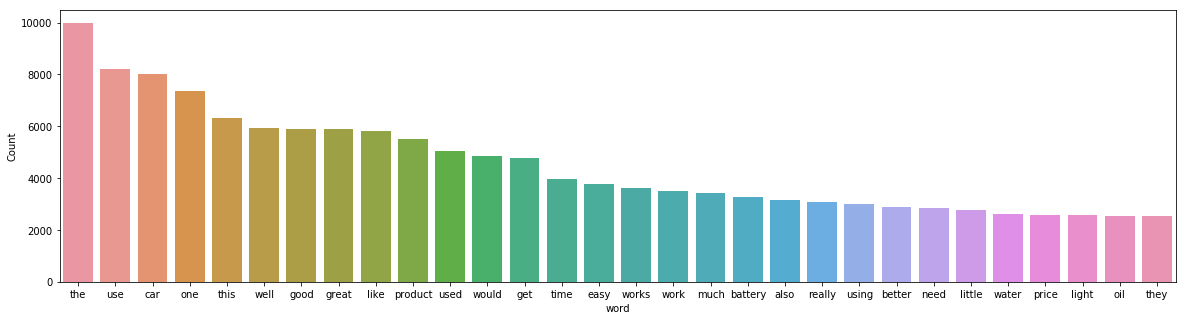

In [6]:
# Plot the bar chart again
mostFrequent(df['reviewText'])

To further remove noise from the text, we can use lemmatization(Reduces the words to its base form)

In [25]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
from nltk import pos_tag as pos

def lemmatization(texts, tags=['NN','NNS','NNP','NNPS', 'JJ', 'JJR', 'JJS']):
    
    postag=pos(texts)
    texts= [x[0] for x in postag if x[1] in tags]
    return([lemmatizer.lemmatize(t) for t in texts])


In [26]:
tokenized_reviews= pd.Series(df['reviewText']).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [27]:
lemmatized_reviews=tokenized_reviews.apply(lambda x: lemmatization(x))
print(lemmatized_reviews)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      [jumper, new, car, good, review, good, price, time, complaint, foot, ideal, length, sure, pull, front, bumper, front, plenty, time, car, close, something, little, longer, great, brand, version]
1                                                                                                                                                                                                              

In [28]:
print(lemmatized_reviews[1])

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


Here, We have not only lemmatized but also kept only word belonging to Noun and Adjectives

In [30]:
df['reviews']=lemmatized_reviews.apply(lambda x:' '.join(x))

In [32]:
df['reviews'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      jumper new car good review good price time complaint foot ideal length sure pull front bumper front plenty time car close something little longer great brand ver

<class 'pandas.core.frame.DataFrame'>


         word  count
2         car   9521
306   product   6966
20      great   5882
3        good   5807
105       use   5777
6        time   4809
51    battery   3801
366      work   3665
181     light   3499
237      easy   3499
271      year   2793
217       oil   2667
5       price   2661
553     water   2604
18     little   2549
109   vehicle   2338
1041   filter   2324
139     thing   2310
1         new   2219
294      tire   2208
27    quality   2201
258       fit   2183
40       nice   2142
174      much   2080
102       way   2073
279       job   2050
544       wax   2005
215     clean   1969
172      last   1938
11       sure   1872


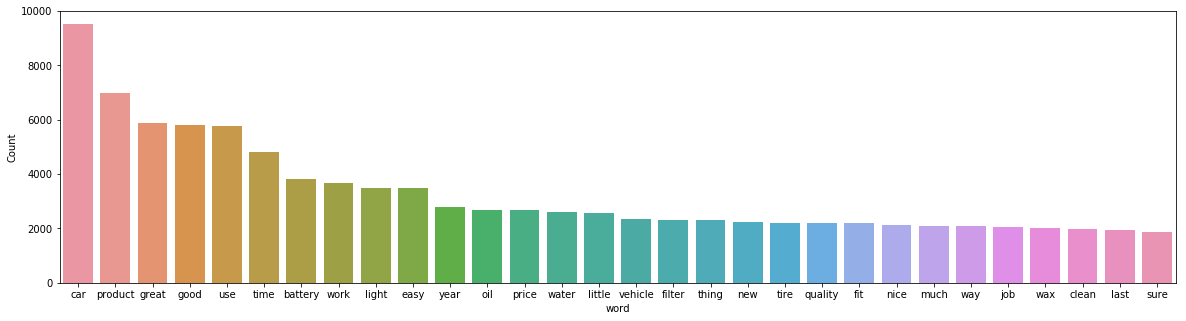

In [33]:
mostFrequent(df['reviews'])

Now, Our text seems to having the good word for the algorithms to be implemented

# Building the LDA Model
start by creating the term dictionary of our corpus, where every unique word is assigned an index

In [34]:
dictionary=corpora.Dictionary(lemmatized_reviews)

In [35]:
dictionary

In [36]:
# Then we will convert the list of reviews(lemmatized_reviews) into a Document Term Matrix using the dictioanry 
# prepared above

doc_term_matrix= [dictionary.doc2bow(rev) for rev in lemmatized_reviews]

# Create the object for LDA model using gensim library
LDA=gensim.models.ldamodel.LdaModel

#Build LDA model
lda_model=LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100, chunksize=1000, passes=50)


The number of topic specified above is 7 using num_topics.
Let's print out the topics that LDA has learned.

In [37]:
lda_model.print_topics()

[(0,
  '0.039*"car" + 0.028*"product" + 0.019*"towel" + 0.014*"use" + 0.013*"water" + 0.012*"wax" + 0.012*"good" + 0.012*"great" + 0.012*"clean" + 0.010*"wash"'),
 (1,
  '0.087*"light" + 0.030*"bulb" + 0.014*"great" + 0.012*"white" + 0.011*"easy" + 0.011*"install" + 0.011*"color" + 0.009*"jeep" + 0.009*"headlight" + 0.009*"night"'),
 (2,
  '0.024*"tire" + 0.014*"hose" + 0.013*"use" + 0.013*"tool" + 0.012*"pressure" + 0.010*"gauge" + 0.010*"time" + 0.010*"air" + 0.007*"adapter" + 0.006*"port"'),
 (3,
  '0.062*"battery" + 0.034*"power" + 0.033*"car" + 0.023*"device" + 0.019*"unit" + 0.019*"charger" + 0.017*"phone" + 0.016*"charge" + 0.014*"cable" + 0.013*"use"'),
 (4,
  '0.025*"oil" + 0.017*"filter" + 0.015*"car" + 0.014*"engine" + 0.014*"water" + 0.012*"change" + 0.010*"tank" + 0.009*"mat" + 0.008*"bright" + 0.008*"vehicle"'),
 (5,
  '0.013*"plastic" + 0.013*"good" + 0.013*"fit" + 0.011*"great" + 0.009*"work" + 0.009*"small" + 0.009*"use" + 0.009*"easy" + 0.009*"little" + 0.009*"cover"'

Topic 3 has word like towel, clean, wax, water: Meaning must be about Car washing.

Topic 6 has word like price, qaulity, worth: Must be about Overall value

# Topic Visualization
To visualize our topics in 2-d space, we will use pyLDAvis library. The visualization is interactive in nature and displays topics along with the most relevant words.

In [38]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/home/raman/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.023943  0.102104       1        1  24.997196
5     -0.126425  0.007068       2        1  17.017643
2     -0.011990  0.036464       3        1  14.294524
4      0.104972  0.156280       4        1  13.655085
6     -0.040874  0.101022       5        1  12.716884
1     -0.197663 -0.224355       6        1   8.914990
3      0.295923 -0.178583       7        1   8.403670, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
154   Default  4260.000000       light  4260.000000  30.0000  30.0000
39    Default  2869.000000     battery  2869.000000  29.0000  29.0000
2     Default  9581.000000         car  9581.000000  28.0000  28.0000
1027  Default  2038.000000       blade  2038.000000  27.0000  27.0000
63    Default  1586.000000       power  1586.000000  26.0000  26.0000
174   Default  1885.000000         oil  1885.000000  25.0000  25.0000
559   Default  2669.000000       towel  2669.000000  24.0000  24.0000
992   Default  1770.000000       wiper  1770.000000  23.0000  23.0000
347   Default  1875.000000        tire  1875.000000  22.0000  22.0000
2719  Default  1461.000000        bulb  1461.000000  21.0000  21.0000
555   Default  2837.000000       water  2837.000000  20.0000  20.0000
328   Default  6382.000000     product  6382.000000  19.0000  19.0000
816   Default  1158.000000      device  1158.000000  18.0000  18.0000
16    Default  2281.000000       price  2281.000000  17.0000  17.0000
1039  Default  1280.000000      filter  1280.000000  16.0000  16.0000
556   Default  1698.000000         wax  1698.000000  15.0000  15.0000
788   Default  1211.000000        unit  1211.000000  14.0000  14.0000
784   Default  1112.000000        hose  1112.000000  13.0000  13.0000
1265  Default   858.000000     charger   858.000000  12.0000  12.0000
554   Default  1422.000000        wash  1422.000000  11.0000  11.0000
118   Default  1208.000000      engine  1208.000000  10.0000  10.0000
5250  Default   773.000000       phone   773.000000   9.0000   9.0000
510   Default  1615.000000     plastic  1615.000000   8.0000   8.0000
44    Default   762.000000      charge   762.000000   7.0000   7.0000
1181  Default   944.000000    pressure   944.000000   6.0000   6.0000
843   Default  1276.000000        plug  1276.000000   5.0000   5.0000
809   Default  1149.000000        tool  1149.000000   4.0000   4.0000
24    Default   663.000000       cable   663.000000   3.0000   3.0000
1153  Default   941.000000      change   941.000000   2.0000   2.0000
642   Default   861.000000       white   861.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
7178   Topic7   128.984726         gps   129.719986   2.4708  -5.8829
1173   Topic7   125.792488       meter   126.528580   2.4707  -5.9080
1763   Topic7   125.696106        mode   126.432030   2.4707  -5.9087
2939   Topic7   117.905060        lead   118.641037   2.4703  -5.9727
7266   Topic7   114.826546       crash   115.568565   2.4701  -5.9992
2551   Topic7   104.733360     monitor   105.469368   2.4695  -6.0912
1273   Topic7   101.066399      gadget   101.803902   2.4692  -6.1268
1257   Topic7    91.468399     trickle    92.203064   2.4685  -6.2266
7197   Topic7    91.687973     android    92.425529   2.4685  -6.2242
5499   Topic7    91.216957      status    91.952431   2.4685  -6.2293
63     Topic7  1552.656982       power  1586.833252   2.4547  -3.3949
816    Topic7  1083.600098      device  1158.586304   2.4096  -3.7545
788    Topic7   900.601074        unit  1211.133545   2.1803  -3.9395
3005   Topic7   309.716431   automatic   379.569794   2.2731  -5.0069
793    Topic7   393.751312   connector   522.356750   2.1939  -4.7669
293    Topic7   234.211304     current   284.343475   2.2825  -5.2864
830    Topic7   193.919830    computer   

# Other Methods to Leverage Online Reviews
Apart from topic modeling, there are many other NLP methods as well which are used for analyzing and understanding online reviews. Some of them are listed below:

Text Summarization: Summarize the reviews into a paragraph or a few bullet points.

Entity Recognition: Extract entities from the reviews and identify which products are most popular (or unpopular) among the consumers.

Identify Emerging Trends: Based on the timestamp of the reviews, new and emerging topics or entities can be identified. It would enable us to figure out which products are becoming popular and which are losing their grip on the market.

Sentiment Analysis: For retailers, understanding the sentiment of the reviews can be helpful in improving their products and services.